# Exploratory Data Analysis (EDA)
## Анализ датасета наблюдений за крокодилами
### Василевская Анна, группа A4140, ИСУ 336429
**Датасет:** https://www.kaggle.com/datasets/zadafiyabhrami/global-crocodile-species-dataset

## 1. Введение

### Цель анализа
Провести оценку качества данных с целью:
- Проверки структуры и схемы данных
- Оценки полноты и целостности данных
- Выявления аномалий и выбросов
- Определения готовности данных для обработки в ETL-пайплайне

### Описание датасета
**Датасет:** 1000 наблюдений за крокодилами, 15 полей

**Структура:**
- Идентификационные данные (ID наблюдения)
- Таксономическая информация (название, семейство, род)
- Физические параметры (длина, вес)
- Демографические данные (возрастной класс, пол)
- Временные и географические характеристики
- Природоохранный статус
- Метаданные наблюдений

### Инструменты
- **Pandera** - валидация схемы данных
- **Pandas** - статистический анализ
- **Matplotlib** - для графиков

In [42]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import pandera as pa
from pandera import Column, DataFrameSchema, Check

# Настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

print("Импорт успешный")


Импорт успешный


## 2. Понимание контекста и источников данных

### Источник данных
- **Источник:** Google Drive (изначально Kaggle)
- **Формат исходных данных:** CSV
- **Формат хранения:** Parquet
- **Частота обновления:** статический датасет

### Ожидания
- уникальный идентификатор
- длина, вес должны быть > 0
- даты наблюдений должны быть адекватными и не превышать текущую дату
- природоохранный статус - стандартная классификация
- обязательные поля: ID, название вида, дата наблюдения


In [43]:
file_id = "1ck8GJFPYxAXKLnl8wyGz3qa5EM4t-LPU"
file_url = f"https://drive.google.com/uc?id={file_id}"

print("Загрузка данных из Google Drive...")
df = pd.read_csv(file_url)

print(f"Данные успешно загружены")
print(f"Размерность датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")


Загрузка данных из Google Drive...
Данные успешно загружены
Размерность датасета: 1000 строк, 15 столбцов


## 3. Первичная структурная проверка

**Задачи:**
- Проверить наличие всех ожидаемых столбцов
- Проверить типы данных
- Оценить первичное состояние данных
- Провести валидацию схемы


In [44]:
print("Первые 10 строк датасета")
display(df.head(10))


Первые 10 строк датасета


,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.00,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.50,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.20,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.40,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.40,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...
5,6,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,2.64,137.40,Adult,Male,08-06-2023,India,Reservoirs,Vulnerable,Randy Brown,Source husband at tree note responsibility def...
6,7,Siamese Crocodile,Crocodylus siamensis,Crocodylidae,Crocodylus,2.85,157.70,Subadult,Male,10-12-2010,Thailand,Slow Rivers,Critically Endangered,Dr. Marvin Thomas Jr.,Much section investment on gun young catch man...
7,8,Congo Dwarf Crocodile,Osteolaemus osborni,Crocodylidae,Osteolaemus,0.35,4.70,Juvenile,Unknown,03-08-2008,Central African Republic,Forest Swamps,Data Deficient,Terri Frazier,Race Mr environment political born itself law ...
8,9,West African Crocodile,Crocodylus suchus,Crocodylidae,Crocodylus,3.05,201.20,Adult,Male,16-04-2020,Sudan,Lakes,Least Concern,Deborah Mason,Medical blood personal success medical current...
9,10,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,3.39,197.20,Adult,Male,21-05-2016,Mexico,Lagoons,Least Concern,Tamara George,Affect upon these story film around there wate...


In [45]:
print("Информация о датасете (исходные типы)")
print(df.info())

Информация о датасете (исходные типы)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null   object 
 14  Notes                 1000 non-null

In [46]:
print("Приведение типов данных...")

# Числовые типы
df['Observation ID'] = df['Observation ID'].astype('uint16')
df['Observed Length (m)'] = df['Observed Length (m)'].astype('float32')
df['Observed Weight (kg)'] = df['Observed Weight (kg)'].astype('float32')

# Категориальные типы
categorical_columns = [
    'Common Name', 'Scientific Name', 'Family', 'Genus',
    'Age Class', 'Sex', 'Country/Region', 'Habitat Type',
    'Conservation Status', 'Observer Name'
]
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Временные типы
df['Date of Observation'] = pd.to_datetime(df['Date of Observation'], format='%d-%m-%Y')

# Notes оставляем как object
df['Notes'] = df['Notes'].astype('object')

print("Типы данных приведены")
print("\nИнформация о датасете (после приведения типов)")
print(df.info())


Приведение типов данных...
Типы данных приведены

Информация о датасете (после приведения типов)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Observation ID        1000 non-null   uint16        
 1   Common Name           1000 non-null   category      
 2   Scientific Name       1000 non-null   category      
 3   Family                1000 non-null   category      
 4   Genus                 1000 non-null   category      
 5   Observed Length (m)   1000 non-null   float32       
 6   Observed Weight (kg)  1000 non-null   float32       
 7   Age Class             1000 non-null   category      
 8   Sex                   1000 non-null   category      
 9   Date of Observation   1000 non-null   datetime64[ns]
 10  Country/Region        1000 non-null   category      
 11  Habitat Type          1000 non-null   

In [47]:
print("Создание схемы валидации данных с Pandera")

# Определяем схему датасета с бизнес-правилами
schema = DataFrameSchema({
    'Observation ID': Column(
        int, 
        checks=[
            Check.greater_than(0),  # ID должен быть положительным
        ],
        nullable=False,
        coerce=True,
        description="Уникальный идентификатор наблюдения"
    ),
    'Common Name': Column(
        'category',
        nullable=False,
        description="Общепринятое название вида"
    ),
    'Scientific Name': Column(
        'category',
        nullable=False,
        description="Научное название вида"
    ),
    'Family': Column(
        'category',
        nullable=False,
        description="Семейство"
    ),
    'Genus': Column(
        'category',
        nullable=False,
        description="Род"
    ),
    'Observed Length (m)': Column(
        float,
        checks=[
            Check.greater_than(0),  # Длина должна быть положительной
            Check.less_than(10)     # до 10 метров
        ],
        nullable=True,  # Может отсутствовать
        coerce=True
    ),
    'Observed Weight (kg)': Column(
        float,
        checks=[
            Check.greater_than(0),  # Вес должен быть положительным
            Check.less_than(1500) # Разумное ограничение
        ],
        nullable=True,  # Может отсутствовать
        coerce=True
    ),
    'Age Class': Column(
        'category',
        checks=[Check.isin(['Adult', 'Subadult', 'Juvenile', 'Hatchling', 'Unknown'])],
        nullable=True
    ),
    'Sex': Column(
        'category',
        checks=[Check.isin(['Male', 'Female', 'Unknown'])],
        nullable=True
    ),
    'Date of Observation': Column(
        'datetime64[ns]',
        checks=[
            Check.less_than_or_equal_to(pd.Timestamp.now())  # Дата не в будущем
        ],
        nullable=False
    ),
    'Country/Region': Column(
        'category',
        nullable=False
    ),
    'Habitat Type': Column(
        'category',
        nullable=False
    ),
    'Conservation Status': Column(
        'category',
        checks=[Check.isin(['Least Concern', 'Vulnerable', 'Endangered', 
                           'Critically Endangered', 'Near Threatened', 'Data Deficient'])],
        nullable=False
    ),
    'Observer Name': Column(
        'category',
        nullable=False
    ),
    'Notes': Column(
        object,
        nullable=True
    )
}, 
    strict=True,  # Не допускаем лишних столбцов
    coerce=True   # Автоматически приводить типы где возможно
)

print("Схема создана успешно")


Создание схемы валидации данных с Pandera
Схема создана успешно


In [48]:
print("Валидация данных")

try:
    validated_df = schema.validate(df, lazy=True)  # lazy=True для сбора всех ошибок
    print("Валидация пройдена успешно!")
    print(f"Количество провалидированных записей: {len(validated_df)}")
except pa.errors.SchemaErrors as e:
    print("Обнаружены ошибки валидации")
    print(f"\nВсего ошибок: {len(e.failure_cases)}")
    print("\nПримеры ошибок:")
    display(e.failure_cases.head(20))
    
    # Продолжаем работу с исходными данными
    validated_df = df.copy()


Валидация данных
Обнаружены ошибки валидации

Всего ошибок: 9

Примеры ошибок:


,schema_context,column,check,check_number,failure_case,index
0,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-12-11,153
1,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-12-06,269
2,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-10-30,291
3,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-11-12,359
4,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-11-24,462
5,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-12-23,540
6,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-11-27,635
7,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-10-20,884
8,Column,Date of Observation,less_than_or_equal_to(2025-10-13 13:34:18.332715),0,2025-12-23,977


### Выводы по структурной проверке

**Результаты:**
- 1000 записей, 15 столбцов
- Типы оптимизированы (категории, float32, uint16, datetime)
- Pandera схема создана с бизнес-правилами

**Обнаруженные проблемы:**
- 9 дат в будущем (0.9%)

## 4. Оценка целостности и полноты данных

**Задачи:**
- Подсчитать долю пропусков по полям
- Проверить уникальность идентификаторов
- Найти дубликаты
- Оценить временной охват данных
- Проверить распределение категориальных переменных


In [49]:
print("Анализ пропущенных значений\n")

# Подсчет пропусков
missing_stats = pd.DataFrame({
    'Количество пропусков': df.isna().sum(),
    'Доля пропусков (%)': (df.isna().mean() * 100).round(2),
    'Количество заполненных': df.notna().sum()
})

missing_stats = missing_stats.sort_values('Доля пропусков (%)', ascending=False)

print("Статистика пропущенных значений по столбцам:")
display(missing_stats)

# Визуальная оценка
fields_with_missing = missing_stats[missing_stats['Доля пропусков (%)'] > 0]
if len(fields_with_missing) > 0:
    print(f"\n Обнаружены пропуски в {len(fields_with_missing)} столбцах")
    print("\nСтолбцы с пропусками:")
    for col in fields_with_missing.index:
        print(f"  - {col}: {fields_with_missing.loc[col, 'Доля пропусков (%)']}%")
else:
    print("\nПропусков не обнаружено")


Анализ пропущенных значений

Статистика пропущенных значений по столбцам:


,Количество пропусков,Доля пропусков (%),Количество заполненных
Observation ID,0,0.00,1000
Common Name,0,0.00,1000
Scientific Name,0,0.00,1000
Family,0,0.00,1000
Genus,0,0.00,1000
Observed Length (m),0,0.00,1000
Observed Weight (kg),0,0.00,1000
Age Class,0,0.00,1000
Sex,0,0.00,1000
Date of Observation,0,0.00,1000



Пропусков не обнаружено


In [50]:
print("Проверка уникальности идентификаторов\n")

# Проверка уникальности Observation ID
total_records = len(df)
unique_ids = df['Observation ID'].nunique()
is_unique = df['Observation ID'].is_unique

print(f"Всего записей: {total_records}")
print(f"Уникальных ID: {unique_ids}")
print(f"Все ID уникальны: {'Да' if is_unique else 'Нет'}")

if not is_unique:
    duplicated_ids = df[df.duplicated(subset=['Observation ID'], keep=False)]
    print(f"\n Обнаружено {len(duplicated_ids)} записей с дублирующимися ID")
    print("\nПримеры дублирующихся ID:")
    display(duplicated_ids.head(10))
    
# Проверка полных дубликатов (все поля одинаковые)
full_duplicates = df.duplicated().sum()
print(f"\nПолных дубликатов строк: {full_duplicates}")
if full_duplicates > 0:
    print(f" Обнаружено {full_duplicates} полностью дублирующихся записей")
else:
    print("Полных дубликатов не обнаружено")


Проверка уникальности идентификаторов

Всего записей: 1000
Уникальных ID: 1000
Все ID уникальны: Да

Полных дубликатов строк: 0
Полных дубликатов не обнаружено


In [51]:
print("Анализ временного диапазона данных\n")

date_min = df['Date of Observation'].min()
date_max = df['Date of Observation'].max()
date_range = (date_max - date_min).days

print(f"Самая ранняя дата наблюдения: {date_min.strftime('%d-%m-%Y')}")
print(f"Самая поздняя дата наблюдения: {date_max.strftime('%d-%m-%Y')}")
print(f"Временной диапазон: {date_range} дней ({date_range/365.25:.1f} лет)")

# Проверка на будущие даты
future_dates = df[df['Date of Observation'] > pd.Timestamp.now()]
if len(future_dates) > 0:
    print(f"\n Обнаружено {len(future_dates)} наблюдений с датой в будущем")
else:
    print("\nДаты в будущем не обнаружены")

# Распределение по годам
print("\nРаспределение наблюдений по годам:")
yearly_counts = df['Date of Observation'].dt.year.value_counts().sort_index()
print(yearly_counts)


Анализ временного диапазона данных

Самая ранняя дата наблюдения: 29-01-2005
Самая поздняя дата наблюдения: 23-12-2025
Временной диапазон: 7633 дней (20.9 лет)

 Обнаружено 9 наблюдений с датой в будущем

Распределение наблюдений по годам:
Date of Observation
2005    42
2006    40
2007    52
2008    50
2009    42
2010    47
2011    52
2012    56
2013    49
2014    44
2015    45
2016    40
2017    55
2018    51
2019    53
2020    60
2021    48
2022    48
2023    45
2024    37
2025    44
Name: count, dtype: int64


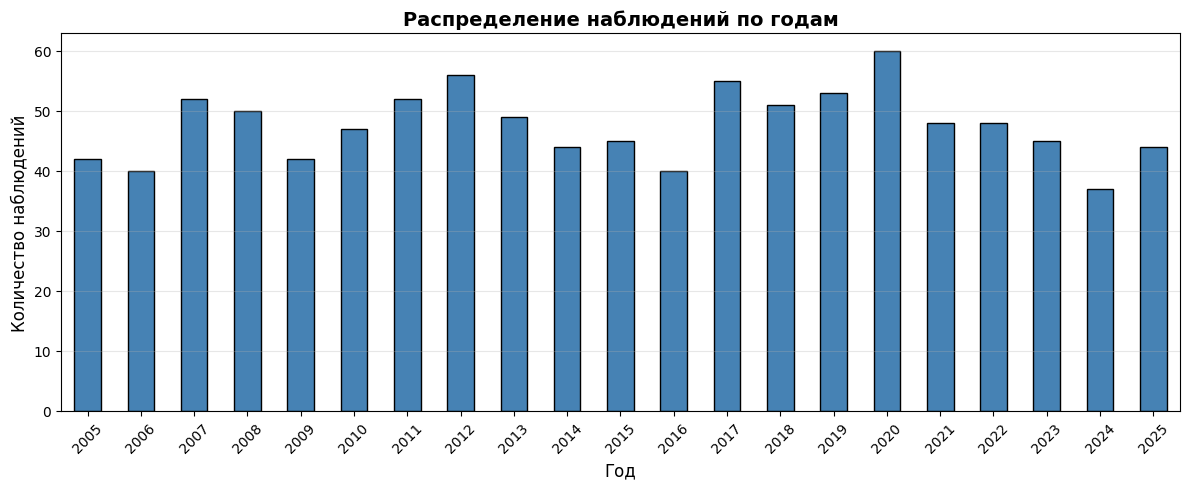


Временной охват: 2005-2025 (21 лет)


In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
yearly_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Распределение наблюдений по годам', fontsize=14, fontweight='bold')
ax.set_xlabel('Год', fontsize=12)
ax.set_ylabel('Количество наблюдений', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nВременной охват: {date_min.year}-{date_max.year} ({date_max.year - date_min.year + 1} лет)")


### Выводы по наблюдениям

**Результаты:**
- Количество наблюдений в год распределено равномерно на протяжении всего периода времени, среднее кол-во наблюдений 45 в год

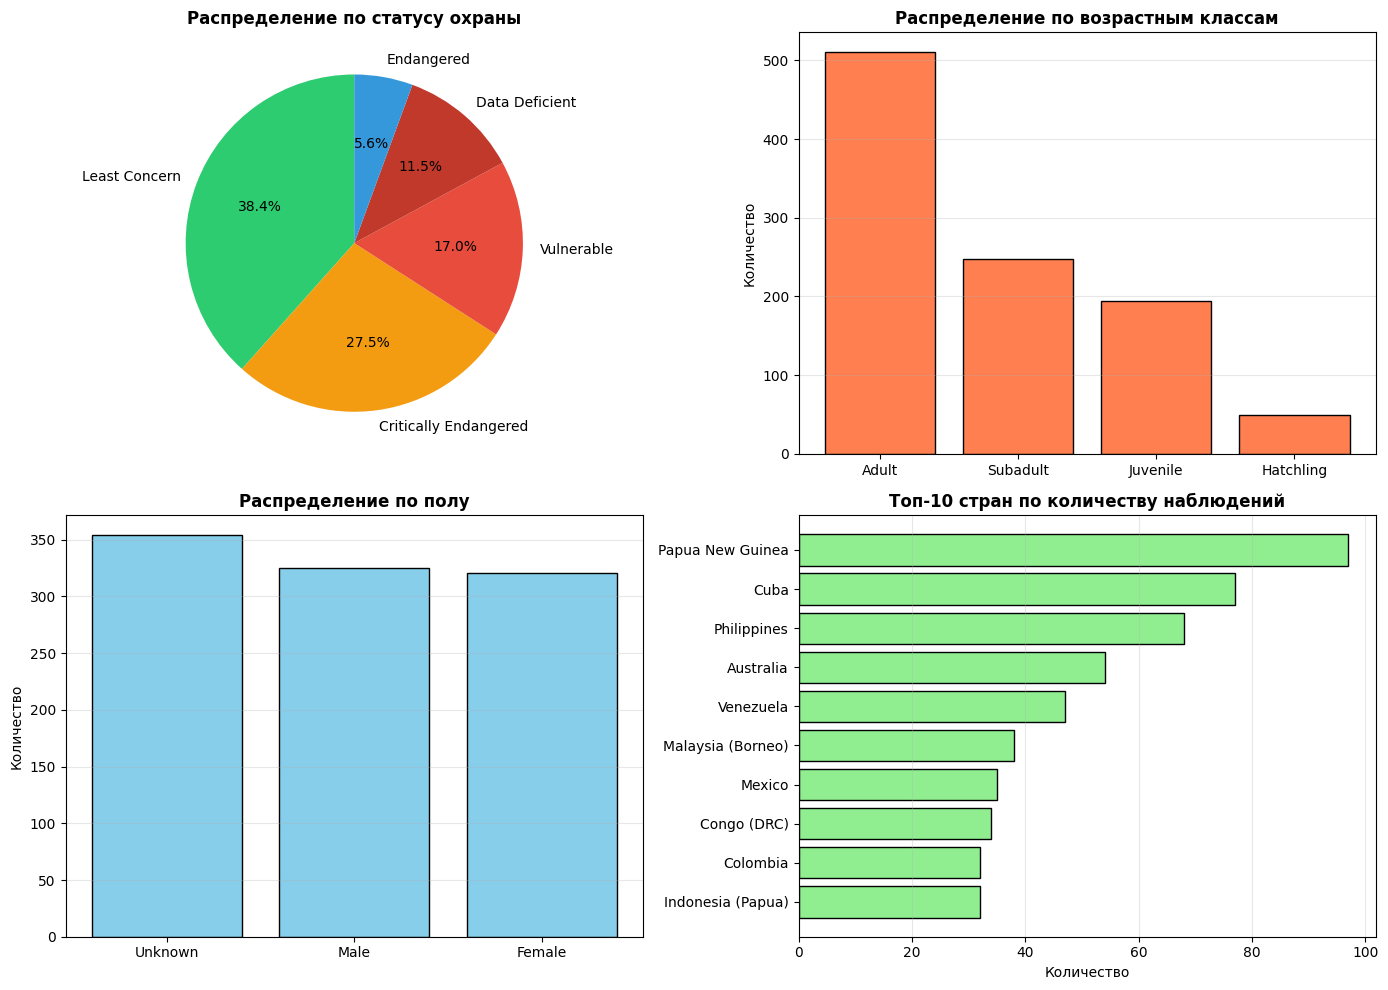

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Conservation Status
status_counts = df['Conservation Status'].value_counts()
axes[0, 0].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=['#2ecc71', '#f39c12', '#e74c3c', '#c0392b', '#3498db'])
axes[0, 0].set_title('Распределение по статусу охраны', fontweight='bold')

# Age Class
age_counts = df['Age Class'].value_counts()
axes[0, 1].bar(age_counts.index, age_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_title('Распределение по возрастным классам', fontweight='bold')
axes[0, 1].set_ylabel('Количество')
axes[0, 1].grid(axis='y', alpha=0.3)

# Sex
sex_counts = df['Sex'].value_counts()
axes[1, 0].bar(sex_counts.index, sex_counts.values, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Распределение по полу', fontweight='bold')
axes[1, 0].set_ylabel('Количество')
axes[1, 0].grid(axis='y', alpha=0.3)

# Топ-10 стран
country_counts = df['Country/Region'].value_counts().head(10)
axes[1, 1].barh(country_counts.index[::-1], country_counts.values[::-1], color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Топ-10 стран по количеству наблюдений', fontweight='bold')
axes[1, 1].set_xlabel('Количество')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Выводы распределениям

**Результаты:**
- Больше всего наблюдений за крокодилами, представляющими "наименьшее беспокойство", меньше всего - за "вызывающими угрозу" 
- Лучше всего удается наблюдать за взрослыми особями
- Примерно в трети случаев наблюдения не удается определить пол особи
- Наибольшее количество наблюдений сделано в Папуа Новой Гвинеи, Кубе и Филиппинах

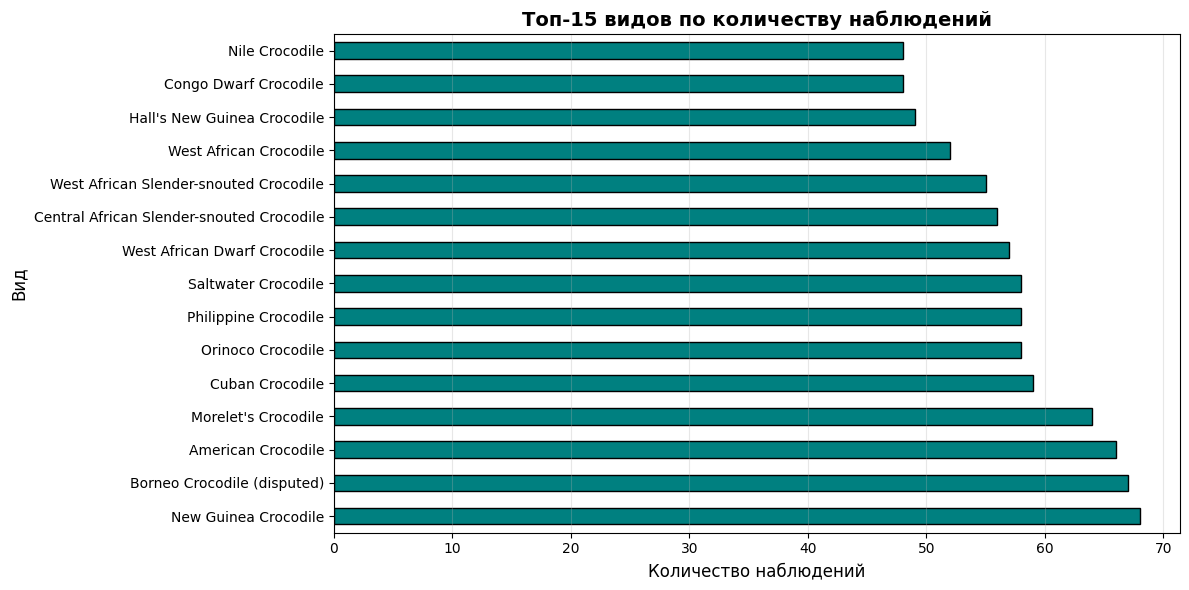

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
species_counts = df['Common Name'].value_counts().head(15)
species_counts.plot(kind='barh', ax=ax, color='teal', edgecolor='black')
ax.set_title('Топ-15 видов по количеству наблюдений', fontsize=14, fontweight='bold')
ax.set_xlabel('Количество наблюдений', fontsize=12)
ax.set_ylabel('Вид', fontsize=12)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Выводы графику наблюдений

**Результаты:**
- Оси были поменяны местами для удобства прочтения названия видов
- Меньше всего наблюдений за Нильским крокодилом, больше всего - за Новогвинейским крокодилом

In [55]:
print("Анализ категориальных переменных\n")

categorical_cols = ['Common Name', 'Family', 'Genus', 'Age Class', 'Sex', 
                   'Country/Region', 'Habitat Type', 'Conservation Status']

for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"\n{col}:")
    print(f"  Уникальных значений: {unique_count}")
    
    # Показываем топ значений для полей с разумным количеством категорий
    if unique_count <= 20:
        print(f"  Распределение:")
        value_counts = df[col].value_counts()
        for val, count in value_counts.items():
            pct = (count / len(df)) * 100
            print(f"    - {val}: {count} ({pct:.1f}%)")
    else:
        print(f"  Топ-5 значений:")
        value_counts = df[col].value_counts().head(5)
        for val, count in value_counts.items():
            pct = (count / len(df)) * 100
            print(f"    - {val}: {count} ({pct:.1f}%)")


Анализ категориальных переменных


Common Name:
  Уникальных значений: 18
  Распределение:
    - New Guinea Crocodile: 68 (6.8%)
    - Borneo Crocodile (disputed): 67 (6.7%)
    - American Crocodile: 66 (6.6%)
    - Morelet's Crocodile: 64 (6.4%)
    - Cuban Crocodile: 59 (5.9%)
    - Orinoco Crocodile: 58 (5.8%)
    - Philippine Crocodile: 58 (5.8%)
    - Saltwater Crocodile: 58 (5.8%)
    - West African Dwarf Crocodile: 57 (5.7%)
    - Central African Slender-snouted Crocodile: 56 (5.6%)
    - West African Slender-snouted Crocodile: 55 (5.5%)
    - West African Crocodile: 52 (5.2%)
    - Hall's New Guinea Crocodile: 49 (4.9%)
    - Congo Dwarf Crocodile: 48 (4.8%)
    - Nile Crocodile: 48 (4.8%)
    - Mugger Crocodile (Marsh Crocodile): 47 (4.7%)
    - Freshwater Crocodile (Johnstone's): 45 (4.5%)
    - Siamese Crocodile: 45 (4.5%)

Family:
  Уникальных значений: 1
  Распределение:
    - Crocodylidae: 1000 (100.0%)

Genus:
  Уникальных значений: 3
  Распределение:
    - Crocodylus: 7

### Выводы по целостности и полноте данных

**Результаты:**
100% - пропусков нет,
100% - все 1000 ID уникальны,
0 - дубликатов не обнаружено

**Проблемы:** 9 наблюдений (0.9%) с датами в будущем - требуют проверки

**Решения:**
- Исправить даты наблюдений
- Добавить валидацию дат при загрузке данных


## 5. Анализ выбросов

**Задачи:**
- Проверить диапазоны числовых значений
- Построить статистики для количественных признаков
- Проверить соответствие разумным значениям
- Найти аномальные значения


In [56]:
print("Статистика числовых признаков\n")

numeric_cols = ['Observed Length (m)', 'Observed Weight (kg)']

# Общая статистика
print("Описательная статистика:")
stats = df[numeric_cols].describe()
display(stats)

# Дополнительная информация
print("\nДополнительная статистика:")
for col in numeric_cols:
    data = df[col].dropna()
    if len(data) > 0:
        print(f"\n{col}:")
        print(f"  Минимум: {data.min():.4f}")
        print(f"  Максимум: {data.max():.4f}")
        print(f"  Среднее: {data.mean():.4f}")
        print(f"  Медиана: {data.median():.4f}")
        print(f"  Стандартное отклонение: {data.std():.4f}")
        print(f"  Квартили: Q1={data.quantile(0.25):.4f}, Q3={data.quantile(0.75):.4f}")
        print(f"  Межквартильный размах (IQR): {data.quantile(0.75) - data.quantile(0.25):.4f}")


Статистика числовых признаков

Описательная статистика:


,Observed Length (m),Observed Weight (kg)
count,1000.00,1000.00
mean,2.42,155.77
std,1.10,175.19
min,0.14,4.40
25%,1.64,53.23
50%,2.43,100.60
75%,3.01,168.88
max,6.12,1139.70



Дополнительная статистика:

Observed Length (m):
  Минимум: 0.1400
  Максимум: 6.1200
  Среднее: 2.4151
  Медиана: 2.4300
  Стандартное отклонение: 1.0975
  Квартили: Q1=1.6375, Q3=3.0100
  Межквартильный размах (IQR): 1.3725

Observed Weight (kg):
  Минимум: 4.4000
  Максимум: 1139.7000
  Среднее: 155.7719
  Медиана: 100.6000
  Стандартное отклонение: 175.1868
  Квартили: Q1=53.2250, Q3=168.8750
  Межквартильный размах (IQR): 115.6500


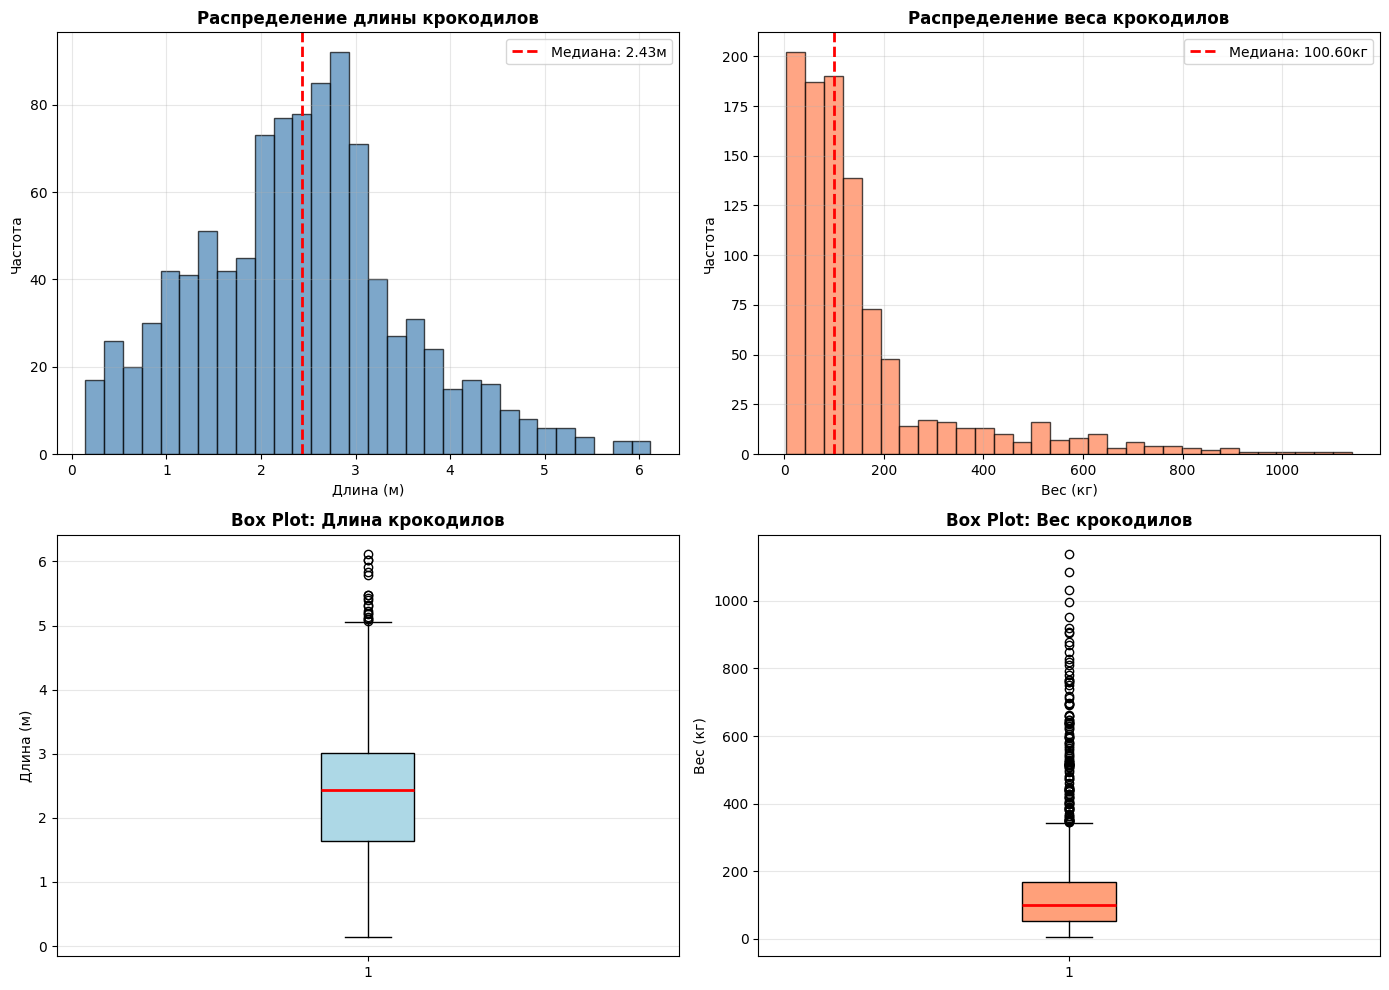

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Гистограмма длины
axes[0, 0].hist(df['Observed Length (m)'].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение длины крокодилов', fontweight='bold')
axes[0, 0].set_xlabel('Длина (м)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].axvline(df['Observed Length (m)'].median(), color='red', linestyle='--', linewidth=2, label=f'Медиана: {df["Observed Length (m)"].median():.2f}м')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Гистограмма веса
axes[0, 1].hist(df['Observed Weight (kg)'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Распределение веса крокодилов', fontweight='bold')
axes[0, 1].set_xlabel('Вес (кг)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].axvline(df['Observed Weight (kg)'].median(), color='red', linestyle='--', linewidth=2, label=f'Медиана: {df["Observed Weight (kg)"].median():.2f}кг')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot длины
axes[1, 0].boxplot(df['Observed Length (m)'].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'))
axes[1, 0].set_title('Box Plot: Длина крокодилов', fontweight='bold')
axes[1, 0].set_ylabel('Длина (м)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Box plot веса
axes[1, 1].boxplot(df['Observed Weight (kg)'].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightsalmon', color='black'),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'))
axes[1, 1].set_title('Box Plot: Вес крокодилов', fontweight='bold')
axes[1, 1].set_ylabel('Вес (кг)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Выводы графикам длины и массы крокодилов

**Результаты:**
- Длина крокодилов может описываться нормальным распределением со средней длиной 2,4 м и отклонением 1м
- Наибольшее количество наблюдаемых крокодилов имеет массу от 4 до 200 кг, распределение массы не может описываться нормалным распределение, возможны аномальные значения (масса больше 1000 кг)

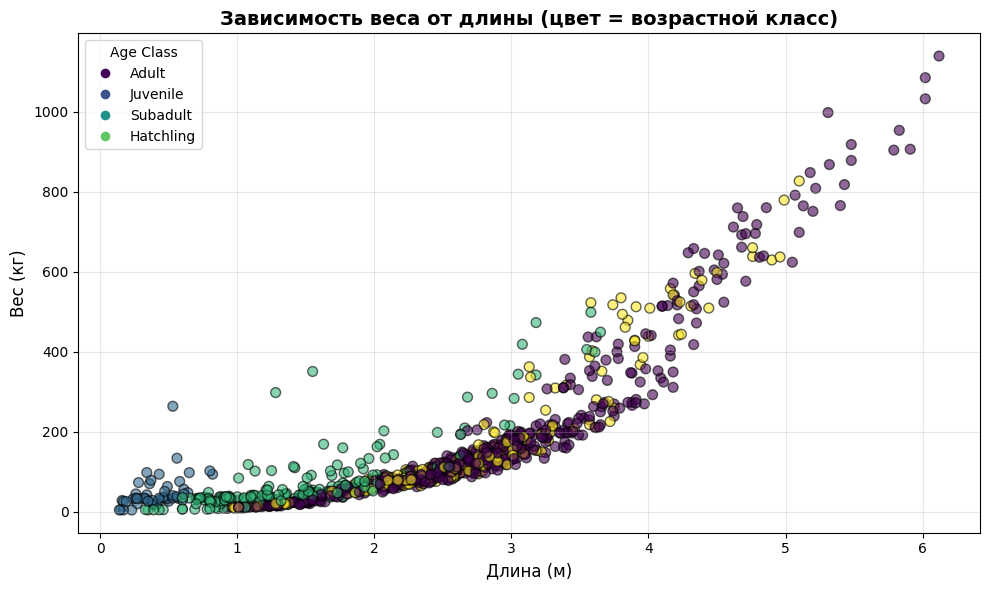

In [58]:
# 5.4. Scatter plot: зависимость веса от длины
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df['Observed Length (m)'], df['Observed Weight (kg)'], 
                     c=df['Age Class'].cat.codes, cmap='viridis', 
                     alpha=0.6, edgecolor='black', s=50)

ax.set_title('Зависимость веса от длины (цвет = возрастной класс)', fontsize=14, fontweight='bold')
ax.set_xlabel('Длина (м)', fontsize=12)
ax.set_ylabel('Вес (кг)', fontsize=12)
ax.grid(alpha=0.3)

age_classes = df['Age Class'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i/len(age_classes)), 
                      markersize=8, label=age) for i, age in enumerate(age_classes)]
ax.legend(handles=handles, title='Age Class', loc='upper left')

plt.tight_layout()
plt.show()


### Выводы графику зависимости

**Результаты:**
- Масса крокодилов закономерно (линия тренда - степенная функция) увеличивается с ростом длины
- Чем старше крокодил, тем большую массу и длину он может иметь

In [59]:
print("Проверка правил\n")

print("1. Проверка положительности физических параметров:")
for col in numeric_cols:
    negative_values = df[df[col] < 0]
    zero_values = df[df[col] == 0]
    
    if len(negative_values) > 0:
        print(f"{col}: Обнаружено {len(negative_values)} отрицательных значений")
    else:
        print(f"{col}: Отрицательных значений не обнаружено")
    
    if len(zero_values) > 0:
        print(f"{col}: Обнаружено {len(zero_values)} нулевых значений (возможна ошибка)")

print("\n2. Проверка разумных диапазонов:")

# длина: от 5 см до 10 м 
unreasonable_length = df[(df['Observed Length (m)'] < 0.05) | (df['Observed Length (m)'] > 10)]
if len(unreasonable_length) > 0:
    print(f"Длина: Обнаружено {len(unreasonable_length)} значений вне разумного диапазона (0.05-10 м)")
else:
    print(f"Длина: все значения в разумном диапазоне")

# вес: от 1 кг до 1500 кг
unreasonable_weight = df[(df['Observed Weight (kg)'] < 1) | (df['Observed Weight (kg)'] > 1500)]
if len(unreasonable_weight) > 0:
    print(f"Вес: обнаружено {len(unreasonable_weight)} значений вне разумного диапазона (1-1500 кг)")
else:
    print(f"Вес: все значения в разумном диапазоне")


Проверка правил

1. Проверка положительности физических параметров:
Observed Length (m): Отрицательных значений не обнаружено
Observed Weight (kg): Отрицательных значений не обнаружено

2. Проверка разумных диапазонов:
Длина: все значения в разумном диапазоне
Вес: все значения в разумном диапазоне


## 6. Поиск выбросов и аномалий

**Цель:** Выявить экстремальные или некорректные значения, которые могут влиять на качество анализа.

**Методы:**
- Метод межквартильного размаха (IQR)
- Z-score для выявления экстремальных отклонений
- Анализ граничных значений


In [60]:
print("Поиск выбросов методом IQR\n")

outliers_summary = {}

for col in numeric_cols:
    data = df[col].dropna()
    
    if len(data) > 0:
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(data)) * 100
        
        outliers_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        print(f"{col}:")
        print(f"Нижняя граница: {lower_bound:.4f}")
        print(f"Верхняя граница: {upper_bound:.4f}")
        print(f"Выбросов обнаружено: {outlier_count} ({outlier_pct:.2f}%)")
        
        if outlier_count > 0:
            print(f"Минимальный выброс: {outliers[col].min():.4f}")
            print(f"Максимальный выброс: {outliers[col].max():.4f}")
        print()


Поиск выбросов методом IQR

Observed Length (m):
Нижняя граница: -0.4213
Верхняя граница: 5.0687
Выбросов обнаружено: 19 (1.90%)
Минимальный выброс: 5.0700
Максимальный выброс: 6.1200

Observed Weight (kg):
Нижняя граница: -120.2500
Верхняя граница: 342.3500
Выбросов обнаружено: 115 (11.50%)
Минимальный выброс: 344.0000
Максимальный выброс: 1139.7000



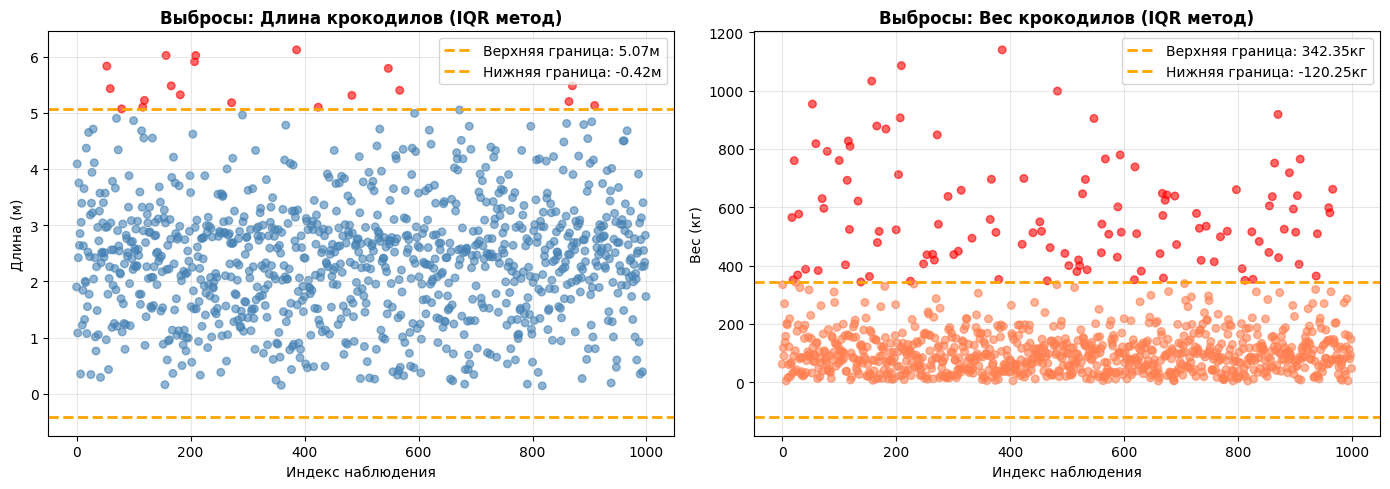

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Выбросы длины
colors_length = ['red' if (x < outliers_summary['Observed Length (m)']['lower_bound'] or 
                           x > outliers_summary['Observed Length (m)']['upper_bound']) 
                 else 'steelblue' for x in df['Observed Length (m)']]
axes[0].scatter(range(len(df)), df['Observed Length (m)'], c=colors_length, alpha=0.6, s=30)
axes[0].axhline(outliers_summary['Observed Length (m)']['upper_bound'], color='orange', 
                linestyle='--', linewidth=2, label=f'Верхняя граница: {outliers_summary["Observed Length (m)"]["upper_bound"]:.2f}м')
axes[0].axhline(outliers_summary['Observed Length (m)']['lower_bound'], color='orange', 
                linestyle='--', linewidth=2, label=f'Нижняя граница: {outliers_summary["Observed Length (m)"]["lower_bound"]:.2f}м')
axes[0].set_title('Выбросы: Длина крокодилов (IQR метод)', fontweight='bold')
axes[0].set_xlabel('Индекс наблюдения')
axes[0].set_ylabel('Длина (м)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Выбросы веса
colors_weight = ['red' if (x < outliers_summary['Observed Weight (kg)']['lower_bound'] or 
                          x > outliers_summary['Observed Weight (kg)']['upper_bound']) 
                else 'coral' for x in df['Observed Weight (kg)']]
axes[1].scatter(range(len(df)), df['Observed Weight (kg)'], c=colors_weight, alpha=0.6, s=30)
axes[1].axhline(outliers_summary['Observed Weight (kg)']['upper_bound'], color='orange', 
                linestyle='--', linewidth=2, label=f'Верхняя граница: {outliers_summary["Observed Weight (kg)"]["upper_bound"]:.2f}кг')
axes[1].axhline(outliers_summary['Observed Weight (kg)']['lower_bound'], color='orange', 
                linestyle='--', linewidth=2, label=f'Нижняя граница: {outliers_summary["Observed Weight (kg)"]["lower_bound"]:.2f}кг')
axes[1].set_title('Выбросы: Вес крокодилов (IQR метод)', fontweight='bold')
axes[1].set_xlabel('Индекс наблюдения')
axes[1].set_ylabel('Вес (кг)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


 ### Выводы графикам выбросов

**Результаты:**
- В данных присутствуют выбросы, представленные необычно крупными крокодилами длиной более 5 метров
- В данных присутствует значительное количество выбросов, представленных очень тяжелыми крокодилами
- На обоих графиках нет нижних выбросов

In [62]:
print("Поиск экстремальных выбросов методом Z-score\n")
print("(Значения с |z-score| > 3 считаются экстремальными)\n")

for col in numeric_cols:
    data = df[col].dropna()
    
    if len(data) > 0:
        mean = data.mean()
        std = data.std()
        
        # Рассчитываем z-score
        z_scores = np.abs((df[col] - mean) / std)
        extreme_outliers = df[z_scores > 3]
        
        extreme_count = len(extreme_outliers)
        extreme_pct = (extreme_count / len(data)) * 100
        
        print(f"{col}:")
        print(f"  Экстремальных выбросов (|z| > 3): {extreme_count} ({extreme_pct:.2f}%)")
        
        if extreme_count > 0:
            print(f"  Примеры экстремальных значений:")
            extreme_values = extreme_outliers[col].head(5)
            for idx, val in extreme_values.items():
                z = np.abs((val - mean) / std)
                print(f"    - {val:.4f} (z-score: {z:.2f})")
        print()


Поиск экстремальных выбросов методом Z-score

(Значения с |z-score| > 3 считаются экстремальными)

Observed Length (m):
  Экстремальных выбросов (|z| > 3): 6 (0.60%)
  Примеры экстремальных значений:
    - 5.8300 (z-score: 3.11)
    - 6.0200 (z-score: 3.28)
    - 5.9100 (z-score: 3.18)
    - 6.0200 (z-score: 3.28)
    - 6.1200 (z-score: 3.38)

Observed Weight (kg):
  Экстремальных выбросов (|z| > 3): 28 (2.80%)
  Примеры экстремальных значений:
    - 759.8000 (z-score: 3.45)
    - 953.9000 (z-score: 4.56)
    - 818.2000 (z-score: 3.78)
    - 791.7000 (z-score: 3.63)
    - 760.5000 (z-score: 3.45)



### Выводы по анализу выбросов

**Результаты:**
- Все физические параметры положительные (нет отрицательных значений)
- Все значения в разумных диапазонах для крокодилов

**Выбросы (метод IQR):**
- **Длина:** 19 выбросов (1.9%) - диапазон 5.07-6.12 м
- **Вес:** 115 выбросов (11.5%) - диапазон 344-1140 кг

**Экстремальные выбросы (Z-score > 3):**
- **Длина:** 6 значений (0.6%)
- **Вес:** 28 значений (2.8%)

**Интерпретация**

Выбросы вероятно реальны (крупные особи), но требуют экспертной оценки


## 7. Метрики качества данных

**Цель:** Количественно оценить качество данных по стандартным метрикам Data Quality.

**Рассчитываемые метрики:**
1. **Completeness** - полнота данных (≥ 0.98)
2. **Uniqueness** - уникальность записей (= 1.0)
3. **Validity** - валидность значений (≥ 0.99)
4. **Duplication Rate** - уровень дубликатов (≤ 0.01)
5. **Outlier Ratio** - доля выбросов (≤ 0.02)


In [63]:
print("РАСЧЕТ МЕТРИК КАЧЕСТВА ДАННЫХ\n")

quality_metrics = {}

# 1. COMPLETENESS (Полнота)
# Измеряет долю непустых значений в каждом поле
print("1. COMPLETENESS (Полнота данных)")
completeness_by_field = df.notna().mean()
overall_completeness = completeness_by_field.mean()

quality_metrics['Completeness'] = {
    'value': overall_completeness,
    'threshold': 0.98,
    'status': 'OK' if overall_completeness >= 0.98 else 'NOT OK'
}

print(f"   Общая полнота датасета: {overall_completeness:.4f} ({overall_completeness*100:.2f}%)")
print(f"   Пороговое значение: ≥ 0.98")
print(f"   Статус: {quality_metrics['Completeness']['status']}")



РАСЧЕТ МЕТРИК КАЧЕСТВА ДАННЫХ

1. COMPLETENESS (Полнота данных)
   Общая полнота датасета: 1.0000 (100.00%)
   Пороговое значение: ≥ 0.98
   Статус: OK


In [64]:
# 2. UNIQUENESS (Уникальность)
# Проверяет, что идентификаторы и ключи не повторяются
print("2. UNIQUENESS (Уникальность записей)")

total_ids = len(df['Observation ID'])
unique_ids = df['Observation ID'].nunique()
uniqueness_ratio = unique_ids / total_ids

quality_metrics['Uniqueness'] = {
    'value': uniqueness_ratio,
    'threshold': 1.0,
    'status': 'OK' if uniqueness_ratio == 1.0 else 'NOT OK'
}

print(f"   Коэффициент уникальности ID: {uniqueness_ratio:.4f}")
print(f"   Уникальных ID: {unique_ids} из {total_ids}")
print(f"   Пороговое значение: = 1.0")
print(f"   Статус: {quality_metrics['Uniqueness']['status']}")
print()


2. UNIQUENESS (Уникальность записей)
   Коэффициент уникальности ID: 1.0000
   Уникальных ID: 1000 из 1000
   Пороговое значение: = 1.0
   Статус: OK



In [65]:
# 3. VALIDITY (Валидность значений)
# Контроль диапазонов, типов и ограничений
print("3. VALIDITY (Валидность значений)")

total_values = 0
valid_values = 0

# Проверка валидности для каждого поля
validity_checks = {
    'Observation ID': lambda x: x > 0,
    'Observed Length (m)': lambda x: (x > 0) & (x < 50),
    'Observed Weight (kg)': lambda x: (x > 0) & (x < 200000),
    'Date of Observation': lambda x: x <= pd.Timestamp.now(),
    'Conservation Status': lambda x: x.isin(['Least Concern', 'Vulnerable', 'Endangered', 
                                             'Critically Endangered', 'Near Threatened', 'Data Deficient'])
}

validity_by_field = {}
for field, check_func in validity_checks.items():
    field_data = df[field].dropna()
    if len(field_data) > 0:
        valid_mask = check_func(field_data)
        field_validity = valid_mask.sum() / len(field_data)
        validity_by_field[field] = field_validity
        total_values += len(field_data)
        valid_values += valid_mask.sum()

overall_validity = valid_values / total_values if total_values > 0 else 0

quality_metrics['Validity'] = {
    'value': overall_validity,
    'threshold': 0.99,
    'status': 'OK' if overall_validity >= 0.99 else 'NOT OK'
}

print(f"   Общая валидность: {overall_validity:.4f} ({overall_validity*100:.2f}%)")
print(f"   Валидных значений: {valid_values} из {total_values}")
print(f"   Пороговое значение: ≥ 0.99")
print(f"   Статус: {quality_metrics['Validity']['status']}")
print(f"\n   Валидность по проверяемым полям:")
for field, validity in validity_by_field.items():
    status_icon = 'OK' if validity >= 0.99 else 'WARN!'
    print(f"     {status_icon} {field}: {validity:.4f} ({validity*100:.2f}%)")
print()


3. VALIDITY (Валидность значений)
   Общая валидность: 0.9982 (99.82%)
   Валидных значений: 4991 из 5000
   Пороговое значение: ≥ 0.99
   Статус: OK

   Валидность по проверяемым полям:
     OK Observation ID: 1.0000 (100.00%)
     OK Observed Length (m): 1.0000 (100.00%)
     OK Observed Weight (kg): 1.0000 (100.00%)
     OK Date of Observation: 0.9910 (99.10%)
     OK Conservation Status: 1.0000 (100.00%)



In [66]:
# 4. DUPLICATION RATE (Уровень дубликатов)
# Измеряет долю повторяющихся строк или ключей
print("4. DUPLICATION RATE (Уровень дубликатов)")

# Полные дубликаты
full_duplicates_count = df.duplicated().sum()
full_duplication_rate = full_duplicates_count / len(df)

# Дубликаты по ID
id_duplicates_count = df.duplicated(subset=['Observation ID']).sum()
id_duplication_rate = id_duplicates_count / len(df)

# Общий уровень дубликатов (берем максимум)
overall_duplication_rate = max(full_duplication_rate, id_duplication_rate)

quality_metrics['Duplication Rate'] = {
    'value': overall_duplication_rate,
    'threshold': 0.01,
    'status': 'OK' if overall_duplication_rate <= 0.01 else 'NOT OK'
}

print(f"   Уровень дубликатов: {overall_duplication_rate:.4f} ({overall_duplication_rate*100:.2f}%)")
print(f"   Пороговое значение: ≤ 0.01 (1%)")
print(f"   Статус: {quality_metrics['Duplication Rate']['status']}")
print(f"\n   Детализация:")
print(f"     - Полные дубликаты строк: {full_duplicates_count} ({full_duplication_rate*100:.2f}%)")
print(f"     - Дубликаты ID: {id_duplicates_count} ({id_duplication_rate*100:.2f}%)")
print()


4. DUPLICATION RATE (Уровень дубликатов)
   Уровень дубликатов: 0.0000 (0.00%)
   Пороговое значение: ≤ 0.01 (1%)
   Статус: OK

   Детализация:
     - Полные дубликаты строк: 0 (0.00%)
     - Дубликаты ID: 0 (0.00%)



In [67]:
# 5. OUTLIER RATIO (Доля выбросов)
# Оценивает процент аномальных или экстремальных значений
print("5. OUTLIER RATIO (Доля выбросов)")

outlier_counts = []
total_numeric_values = 0

for col in numeric_cols:
    data = df[col].dropna()
    if len(data) > 0:
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((data < lower_bound) | (data > upper_bound)).sum()
        outlier_counts.append(outliers)
        total_numeric_values += len(data)

total_outliers = sum(outlier_counts)
outlier_ratio = total_outliers / total_numeric_values if total_numeric_values > 0 else 0

quality_metrics['Outlier Ratio'] = {
    'value': outlier_ratio,
    'threshold': 0.02,
    'status': 'OK' if outlier_ratio <= 0.02 else 'WARN!'
}

print(f"   Доля выбросов: {outlier_ratio:.4f} ({outlier_ratio*100:.2f}%)")
print(f"   Пороговое значение: ≤ 0.02 (2%)")
print(f"   Статус: {quality_metrics['Outlier Ratio']['status']}")
print(f"\n   Детализация:")
print(f"     - Всего выбросов: {total_outliers}")
print(f"     - Всего числовых значений: {total_numeric_values}")
for i, col in enumerate(numeric_cols):
    data = df[col].dropna()
    if len(data) > 0:
        col_ratio = outlier_counts[i] / len(data)
        print(f"     - {col}: {outlier_counts[i]} выбросов ({col_ratio*100:.2f}%)")
print()


5. OUTLIER RATIO (Доля выбросов)
   Доля выбросов: 0.0670 (6.70%)
   Пороговое значение: ≤ 0.02 (2%)
   Статус: WARN!

   Детализация:
     - Всего выбросов: 134
     - Всего числовых значений: 2000
     - Observed Length (m): 19 выбросов (1.90%)
     - Observed Weight (kg): 115 выбросов (11.50%)



In [68]:
print("СВОДНАЯ ТАБЛИЦА МЕТРИК КАЧЕСТВА ДАННЫХ")

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame({
    'Метрика': list(quality_metrics.keys()),
    'Значение': [m['value'] for m in quality_metrics.values()],
    'Порог': [m['threshold'] for m in quality_metrics.values()],
    'Статус': [m['status'] for m in quality_metrics.values()]
})

# Для метрик, где "меньше = лучше", инвертируем отображение
metrics_df['Значение (%)'] = metrics_df['Значение'] * 100
metrics_df['Порог (%)'] = metrics_df['Порог'] * 100

# Переупорядочим столбцы
metrics_df = metrics_df[['Метрика', 'Значение', 'Значение (%)', 'Порог', 'Порог (%)', 'Статус']]

display(metrics_df)

# Общая оценка качества
passed_metrics = sum([1 for m in quality_metrics.values() if m['status'] == 'OK'])
total_metrics = len(quality_metrics)
quality_score = passed_metrics / total_metrics

print(f"ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ: {quality_score*100:.1f}%")
print(f"Пройдено метрик: {passed_metrics} из {total_metrics}")

СВОДНАЯ ТАБЛИЦА МЕТРИК КАЧЕСТВА ДАННЫХ


,Метрика,Значение,Значение (%),Порог,Порог (%),Статус
0,Completeness,1.00,100.00,0.98,98.00,OK
1,Uniqueness,1.00,100.00,1.00,100.00,OK
2,Validity,1.00,99.82,0.99,99.00,OK
3,Duplication Rate,0.00,0.00,0.01,1.00,OK
4,Outlier Ratio,0.07,6.70,0.02,2.00,WARN!


ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ: 80.0%
Пройдено метрик: 4 из 5


## 8. Выводы

Проведен комплексный EDA датасета наблюдений за крокодилами (1000 записей, 15 полей).

### Качество

**Сильные стороны:**
- OK: Completeness: 100% (пропусков нет)
- OK: Uniqueness: 100% (все ID уникальны)
- OK: Validity: 99.82% (почти все валидно)
- OK: Duplication Rate: 0% (дубликатов нет)

**Проблемные области:**
- WARN: Outlier Ratio: 6.70% (превышает порог 2%)
  - Длина: 1.9% выбросов
  - Вес: 11.5% выбросов (главная проблема)
- WARN: 9 наблюдений с датами в будущем (0.9%)


### Рекомендации

1. Исправить 9 дат в будущем
2. Экспертная оценка 115 выбросов веса (11.5%)
3. Проверить 28 экстремальных значений (Z-score > 3)

### Применимость
- **Описательная статистика** - готовы (использовать медиану)
- **Агрегированная аналитика** - готовы
- **Машинное обучение** - требуется обработка выбросов, исправление дат


### Документация

**Характеристики:**
- 1000 записей, 15 полей
- 4/5 метрик пройдены

**Метаданные:**
- Pandera-схема определена
- Категориальные: Conservation Status, Age Class, Sex, и др.
- Числовые: Observed Length (m), Observed Weight (kg)


In [70]:
print("Сохранение обработанных данных\n")

output_path = "../data/raw/dataset.parquet"
df.to_parquet(output_path, index=False)

print(f"Данные сохранены в {output_path}")
print("\nАнализ завершен")


Сохранение обработанных данных

Данные сохранены в ../data/raw/dataset.parquet

Анализ завершен
